# Modeling the Global Spread of COVID - 19 Using An LSTM Neural Network


In this notebook, we will model the global spread of COVID - 19 using confirmed case data and an LSTM neural network model.

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas import DataFrame

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import src.modeling.lstm as lstm
import src.modeling.lstm_graph as lstm_graph


### Background Information

A Long Short-Term Memory (LSTM) neural network is a type of neural network that is good at working with sequential data. For this project, we will be using time series COVID data for the LSTM model.

### Data

Lets look at the data that we will be using for the LSTM model.

In [5]:
confirmed_time_series = read_csv('data/processed/LSTM/global_time_series.csv')

index = confirmed_time_series[confirmed_time_series.columns[0]].values
data = confirmed_time_series[confirmed_time_series.columns[1]].values

covid_values = pd.Series(index = index, data = data)[:'5/31/20']
covid_values

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
5/27/20    5701013
5/28/20    5820462
5/29/20    5941657
5/30/20    6079281
5/31/20    6186675
Length: 131, dtype: int64

### EDA

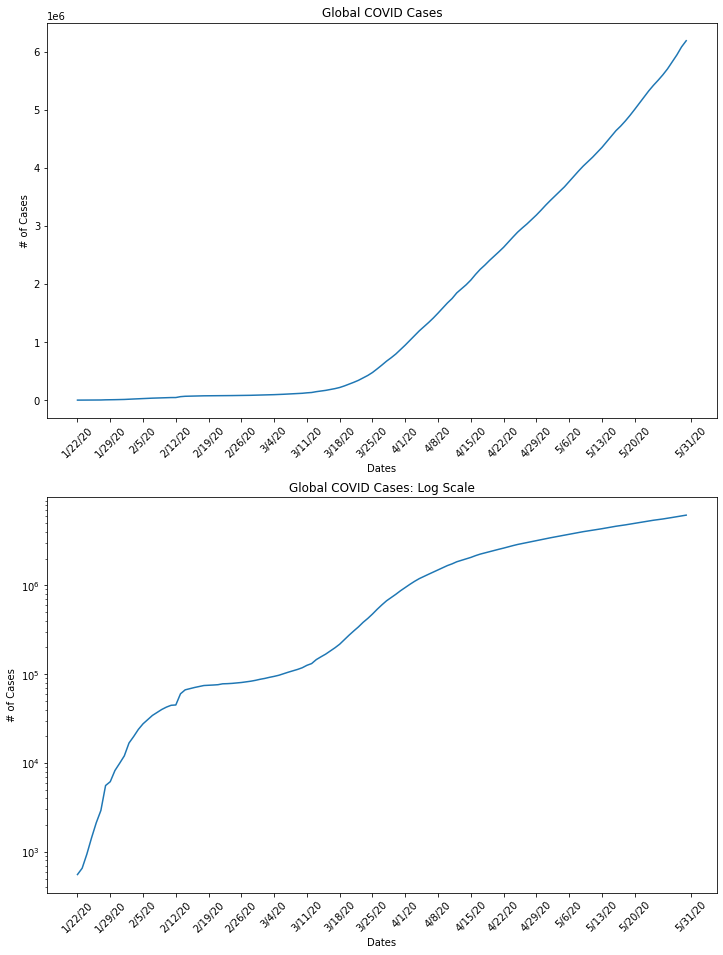

In [6]:
fig = plt.figure(figsize = (12, 16))
ax = fig.add_subplot(211)
ax = lstm_graph.eda_graph(covid_values, ax)
ax.set_title('Global COVID Cases')
ax.set_xlabel('Dates')
ax.set_ylabel('# of Cases')

ax = fig.add_subplot(212)
ax = lstm_graph.eda_graph(covid_values, ax)

ax.set_yscale('log')
ax.set_title('Global COVID Cases: Log Scale')
ax.set_xlabel('Dates')
ax.set_ylabel('# of Cases')

fig.show()

### Create LSTM Model

First, lets split the data into training, validation, and testing sets

In [7]:
# Training and testing datasets
covid_model_values = pd.Series(index = index, data = data)[:'4/30/20']
covid_testing_values = pd.Series(index = index, data = data)['5/1/20':'5/31/20']

# Split datasets into training, validation, and testing sets
X_train, X_valid, y_train, y_valid = lstm.model_data(covid_model_values)
X_test, y_test = lstm.split_sequence(covid_testing_values, 2)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Next, lets create a Vanilla LSTM neural network model.

In [8]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(2,1))) # Specifying input shape for model
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Now, lets train the model using the data we processed earlier, and evaluate its performance using RMSE, which is the root mean squared error between the model's predictions and the testing data.

In [9]:
# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, validation_data=(X_valid, y_valid))

# evaluate the model 
mse, mae = model.evaluate(X_test, y_test, verbose = 0) # mae won't be used

# make a prediction
row = asarray([X_test[0][0], X_test[0][1]]).reshape((1, 2, 1)) 
yhat = model.predict(row)

print('RMSE: %.3f' % (sqrt(mse)))
print('Given inputs of %.3f and %.3f, the model predicts: %.3f' % (X_test[0][0], X_test[0][1], yhat))

RMSE: 70510.713
Given inputs of 3356555.000 and 3437968.000, the model predicts: 3556744.500


### Hyperparameter Tuning


With our baseline LSTM model created, lets do some hyperparameter tuning to see if we can improve model performance. Specifically, we will aim to tune the # of neurons, epochs, and batch size.

Below are the functions that will be used during hyperparameter tuning.

In [8]:
# Functions
def test_neurons(neurons, simulations):
  rtms = []
  for i in range(simulations):
    # print(i)
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', kernel_initializer='he_normal', input_shape=(2,1))) # Specifying input shape for model
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    # fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, validation_data=(X_test, y_test))
    # evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    rtms.append(sqrt(mse))
  return rtms

def test_epochs(epoch_num, simulations):
  rtms = []
  for i in range(simulations):
    # print(i)
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(2,1))) # Specifying input shape for model
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    # fit the model
    model.fit(X_train, y_train, epochs=epoch_num, batch_size=4, verbose=0, validation_data=(X_test, y_test))
    # evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    rtms.append(sqrt(mse))
  return rtms
    
def test_batches(batch, simulations):
  rtms = []
  for i in range(simulations):
    # print(i)
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(2,1))) # Specifying input shape for model
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    # fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=batch, verbose=0, validation_data=(X_test, y_test))
    # evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    rtms.append(sqrt(mse))
  return rtms

First, lets run the LSTM model with varying numbers of neurons and track model performance to find the optimal number.

In [9]:
neuron_test = [100 * n for n in range(1,10)]
resultsNeurons = DataFrame()
for n in neuron_test:
    print("# of neurons: " + str(n))
    resultsNeurons[str(n)] = test_neurons(n, 30)

# of neurons: 100
# of neurons: 200
# of neurons: 300
# of neurons: 400
# of neurons: 500
# of neurons: 600
# of neurons: 700
# of neurons: 800
# of neurons: 900


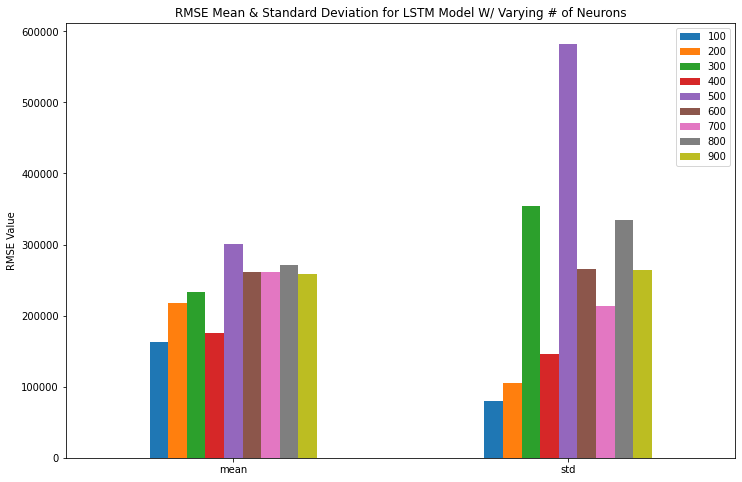

In [10]:
df = resultsNeurons.describe().loc[['mean', 'std']]
ax = df.plot.bar(figsize = (12, 8))
ax.set_title('RMSE Mean & Standard Deviation for LSTM Model W/ Varying # of Neurons')
ax.set_xticklabels(labels = ['mean', 'std'], rotation = 0)
ax.set_ylabel('RMSE Value')
plt.show()

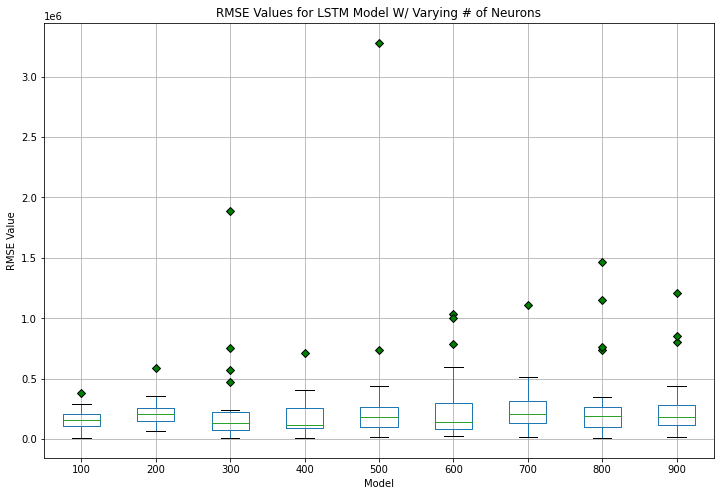

In [11]:
# Make box and whisker plot of data
fig, ax = plt.subplots(figsize = (12, 8))
outlier = dict(markerfacecolor='g', marker='D')
resultsNeurons.boxplot(flierprops=outlier)
ax.set_title('RMSE Values for LSTM Model W/ Varying # of Neurons')
ax.set_ylabel('RMSE Value')
ax.set_xlabel('Model')
plt.show()

Based on the graphs above, 100 neurons has the lowest average rmse value and standard deivation. Because of this, lets go with 100 neurons for our final model.


Next, lets run the LSTM model with varying numbers of epochs and track model performance to find the optimal number.

In [12]:
epoch_test = [100 * n for n in range(1,10)]
results = DataFrame()
for n in epoch_test:
    print("# of epochs: " + str(n))
    results[str(n)] = test_epochs(n, 30)
resultsEpochs = results.rename_axis("Simulation #", axis = 0)

# of epochs: 100
# of epochs: 200
# of epochs: 300
# of epochs: 400
# of epochs: 500
# of epochs: 600
# of epochs: 700
# of epochs: 800
# of epochs: 900


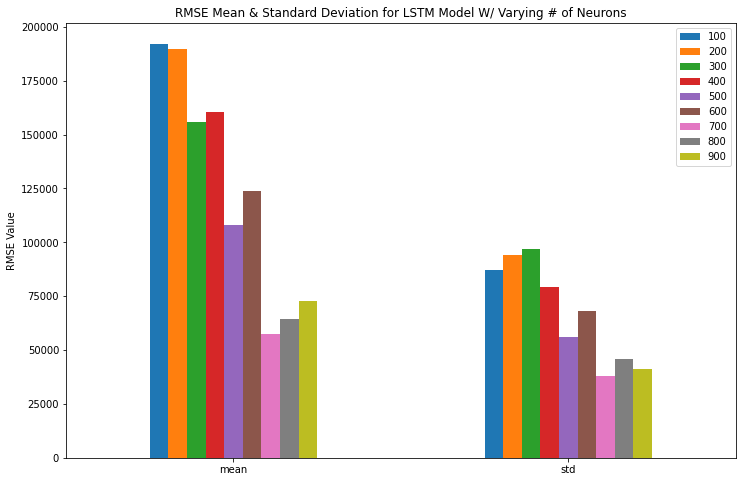

In [13]:
df = resultsEpochs.describe().loc[['mean', 'std']]
ax = df.plot.bar(figsize = (12, 8))
ax.set_title('RMSE Mean & Standard Deviation for LSTM Model W/ Varying # of Neurons')
ax.set_xticklabels(labels = ['mean', 'std'], rotation = 0)
ax.set_ylabel('RMSE Value')
plt.show()

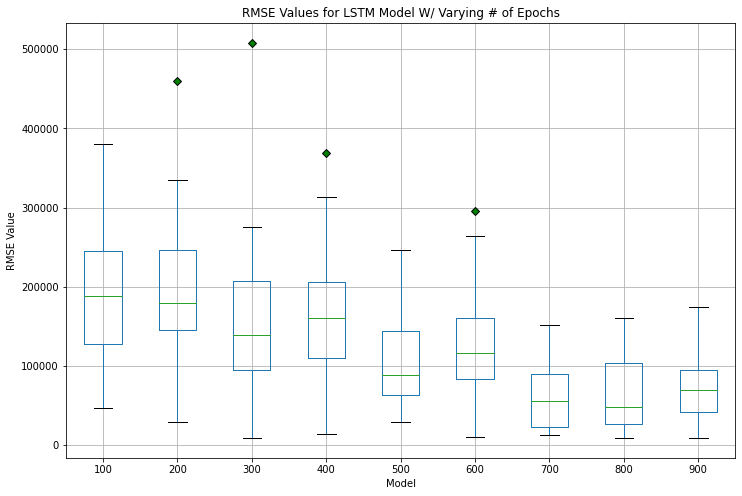

In [14]:
# Make box and whisker plot of data
fig, ax = plt.subplots(figsize = (12, 8))
outlier = dict(markerfacecolor='g', marker='D')
resultsEpochs.boxplot(flierprops=outlier)
ax.set_title('RMSE Values for LSTM Model W/ Varying # of Epochs')
ax.set_ylabel('RMSE Value')
ax.set_xlabel('Model')
plt.show()

Based on the graphs above, 700 epochs has the lowest average rmse value and standard deivation. Because of this, lets go with 700 epochs for our final model.


Finally, lets run the LSTM model with varying batch sizes and track model performance to find the optimal number.

In [15]:
batch_test = [2 * n for n in range(1,21)]
results = DataFrame()
for n in batch_test:
    print("# of batches: " + str(n))
    results[str(n)] = test_batches(n, 30)
resultsBatch = results.rename_axis("Simulation #", axis = 0)

# of batches: 2
# of batches: 4
# of batches: 6
# of batches: 8
# of batches: 10
# of batches: 12
# of batches: 14
# of batches: 16
# of batches: 18
# of batches: 20
# of batches: 22
# of batches: 24
# of batches: 26
# of batches: 28
# of batches: 30
# of batches: 32
# of batches: 34
# of batches: 36
# of batches: 38
# of batches: 40


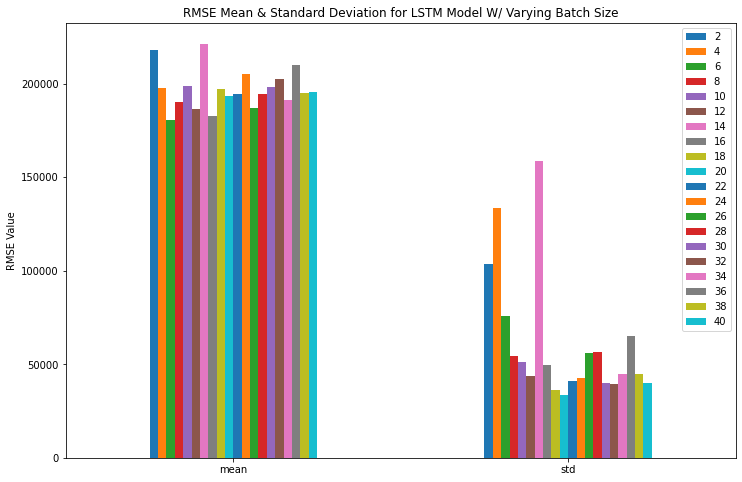

In [16]:
df = resultsBatch.describe().loc[['mean', 'std']]
ax = df.plot.bar(figsize = (12, 8))
ax.set_title('RMSE Mean & Standard Deviation for LSTM Model W/ Varying Batch Size')
ax.set_xticklabels(labels = ['mean', 'std'], rotation = 0)
ax.set_ylabel('RMSE Value')
plt.show()

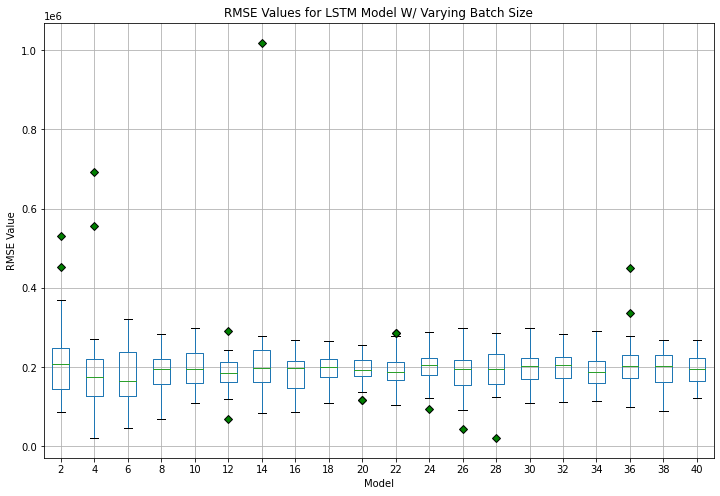

In [17]:
# Make box and whisker plot of data
fig, ax = plt.subplots(figsize = (12, 8))
outlier = dict(markerfacecolor='g', marker='D')
resultsBatch.boxplot(flierprops=outlier)
ax.set_title('RMSE Values for LSTM Model W/ Varying Batch Size')
ax.set_ylabel('RMSE Value')
ax.set_xlabel('Model')
plt.show()

Based on the graphs above, differing batch sizes seem to have relatively similar values of RMSE. Because of this, lets use 20 for our batch size since it has the smallest standard deviation.


Overall, after hyperparameter tuning, we found that the optimal number of neurons is 100, epochs is 700, and batch size is 20.

### Model Performance

Now that we have created a baseline LSTM model and improved it through hyperparameter tuning, lets compare the two models and see how well it predicts COVID - 19 trends.

We'll use the following functions to compare the two models

In [10]:
# Get COVID cases in June
covid_june_values = pd.Series(index = index, data = data)['6/1/20':'6/30/20']

# Model Performance Code
def model(neurons, epochs, batch_size):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', kernel_initializer='he_normal', input_shape=(2,1))) # Specifying input shape for model
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    # fit the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
    return model

def model_performance(model):
    mse, mae = model.evaluate(X_test, y_test, verbose = 0)
    return sqrt(mse)

def lstm_predictions(model):
    results = [covid_june_values[0], covid_june_values[1]]

    # make a prediction
    row = asarray([covid_june_values[0], covid_june_values[1]]).reshape((1, 2, 1)) 
    yhat = model.predict(row)
    results.append(yhat[0][0])

    row = asarray([covid_june_values[1], results[0]]).reshape((1, 2, 1))
    yhat = model.predict(row)
    results.append(yhat[0][0])

    for i in range(26):
        row = asarray([results[i], results[i + 1]]).reshape((1, 2, 1)) 
        yhat = model.predict(row)
        results.append(yhat[0][0])
    
    # print(len(results))
    return results


Lets first compare the two models' average RMSE

In [19]:
# Create DataFrames
rmse_results = DataFrame(columns = ['Baseline', 'Tuned'])
predictions = DataFrame(columns = covid_june_values.index)

# Run 10 simulations
for i in range(10):
    # print(i)

    # Baseline Model
    base_model = model(100, 100, 4)
    rmse_results.loc[i, 'Baseline'] = model_performance(base_model)
    predictions.loc[i, :] = lstm_predictions(base_model)

    # Tuned model
    tuned_model = model(100, 700, 20)
    rmse_results.loc[i, 'Tuned'] = model_performance(tuned_model)
    predictions.loc[i + 10, :] = lstm_predictions(tuned_model)

# Fix data type for box and whisker graph
rmse_results['Baseline'] = rmse_results['Baseline'].astype(float)
rmse_results['Tuned'] = rmse_results['Tuned'].astype(float)


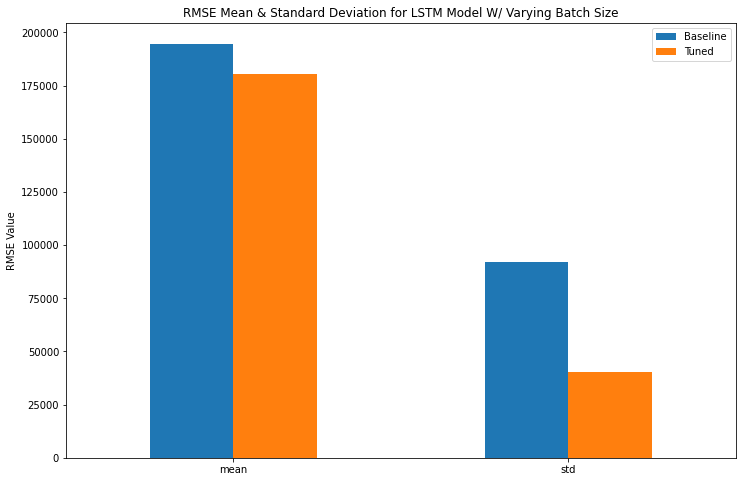

In [20]:
df = rmse_results.describe().loc[['mean', 'std']]
ax = df.plot.bar(figsize = (12, 8))
ax.set_title('RMSE Mean & Standard Deviation for LSTM Model W/ Varying Batch Size')
ax.set_xticklabels(labels = ['mean', 'std'], rotation = 0)
ax.set_ylabel('RMSE Value')
plt.show()

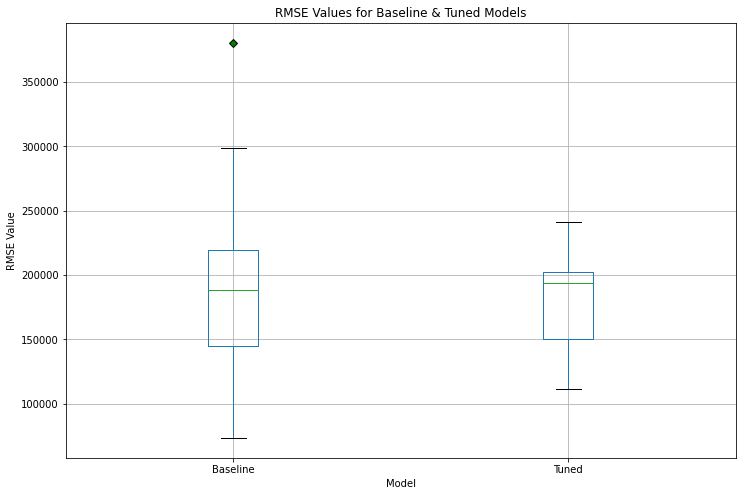

In [21]:
fig, ax = plt.subplots(figsize = (12, 8))
outlier = dict(markerfacecolor='g', marker='D')
rmse_results.boxplot(flierprops=outlier)
ax.set_title('RMSE Values for Baseline & Tuned Models')
ax.set_ylabel('RMSE Value')
ax.set_xlabel('Model')

plt.show()

Based on the graphs above, the Tuned Model has a lower average RMSE and less average variance than the Baseline Model.

Now lets look at how well the baseline and tuned models predicted global COVID cases in the month of June.

In [22]:
def model_graph(ax, label, predictions):
    # x ticks
    tick_loc = [i * 7 for i in range(5)]
    tick_label = [predictions.columns[7 * i] for i in range(5)]
    ax.set_xticks(tick_loc)
    ax.set_xticklabels(tick_label, rotation = 45)

    t = np.linspace(0, len(predictions.columns), len(predictions.columns))

    if label == 'baseline':
      for i in range(10):
          ax.plot(t, predictions.iloc[i, :], label = "Simulation #: " + str(i + 1), alpha = 0.5, marker = 'o', linestyle = 'None')
      ax.plot(t, covid_testing_values, label = 'Actual')

    elif label == 'tuned':
      for i in range(10):
          ax.plot(t, predictions.iloc[i + 10, :], label = "Simulation #: " + str(i + 1), alpha = 0.5, marker = 'o', linestyle = 'None')
      ax.plot(t, covid_testing_values, label = 'Actual')

    elif label == 'compare':
      base = predictions.iloc[0:10, :].sum() / 10
      tune = predictions.iloc[10:19, :].sum() / 10
      ax.plot(t, base, label = 'Base Model Avg.')
      ax.plot(t, tune, label = 'Tuned Model Avg.')
      ax.plot(t, covid_testing_values, label = 'Actual')

    ax.legend()
    return ax

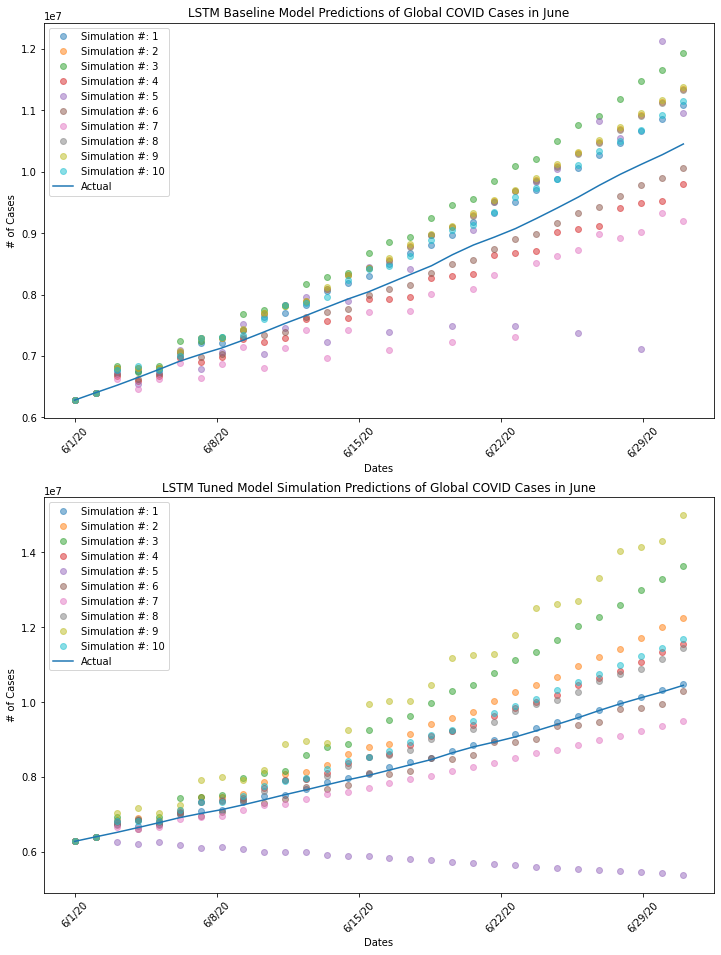

In [26]:
fig = plt.figure(figsize = (12, 16))

ax = fig.add_subplot(211)
ax = lstm_graph.model_graph(ax, 'baseline', predictions, covid_june_values)
ax.set_title('LSTM Baseline Model Predictions of Global COVID Cases in June')
ax.set_xlabel('Dates')
ax.set_ylabel('# of Cases')

ax = fig.add_subplot(212)
ax = lstm_graph.model_graph(ax, 'tuned', predictions, covid_june_values)
ax.set_title('LSTM Tuned Model Simulation Predictions of Global COVID Cases in June')
ax.set_xlabel('Dates')
ax.set_ylabel('# of Cases')

plt.show()

Surprisingly, the Baseline LSTM Model better predicts the number of global COVID cases in June than the Tuned LSTM Model, despite having more variance and a higher average RMSE value.

This concludes the modeling efforts in this notebook.